In [40]:
from pypinyin import lazy_pinyin, Style
import torch

MODELS = {
    'vqvae.pth':'/home/hyc/tortoise_plus_zh/ttts/vqvae/logs/2023-11-24-01-21-25/model-30.pt',
    'gpt.pth': '/home/hyc/tortoise_plus_zh/ttts/gpt/logs/2023-12-24-14-22-14/model-70.pt',
    'clvp2.pth': '',
    'diffusion.pth': '/home/hyc/tortoise_plus_zh/ttts/diffusion/logs/2024-01-09-17-44-36/model-724.pt',
    'vocoder.pth': '~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin',
    'rlg_auto.pth': '',
    'rlg_diffuser.pth': '',
}

In [41]:
from ttts.gpt.voice_tokenizer import VoiceBpeTokenizer
import torch.nn.functional as F
device = 'cuda:2'
# text = "大家好，今天来点大家想看的东西。"
# text = "霞浦县衙城镇乌旗瓦窑村水位猛涨。"
text = '高德官方网站，拥有全面、精准的地点信息，公交驾车路线规划，特色语音导航，商家团购、优惠信息。'
# text = '先帝创业未半而中道崩殂，今天下三分，益州疲弊，此诚危急存亡之秋也。然侍卫之臣不懈于内，忠志之士忘身于外者，盖追先帝之殊遇，欲报之于陛下也。诚宜开张圣听，以光先帝遗德，恢弘志士之气，不宜妄自菲薄，引喻失义，以塞忠谏之路也。'
pinyin = ' '.join(lazy_pinyin(text, style=Style.TONE3, neutral_tone_with_five=True))
tokenizer = VoiceBpeTokenizer('gpt/gpt_tts_tokenizer.json')
text_tokens = torch.IntTensor(tokenizer.encode(pinyin)).unsqueeze(0).to(device)
text_tokens = F.pad(text_tokens, (0, 1))  # This may not be necessary.
text_tokens = text_tokens.to(device)
print(pinyin)
print(text_tokens)

gao1 de2 guan1 fang1 wang3 zhan4 ， yong1 you3 quan2 mian4 、 jing1 zhun3 de5 di4 dian3 xin4 xi1 ， gong1 jiao1 jia4 che1 lu4 xian4 gui1 hua4 ， te4 se4 yu3 yin1 dao3 hang2 ， shang1 jia1 tuan2 gou4 、 you1 hui4 xin4 xi1 。
tensor([[ 15, 105,   2,  12,  81,   2, 118,  71,   2,  14,  86,   2,  31,  92,
           2,  53,  63,   2,  43,   2,  33,  84,   2,  90,   2, 174,  69,   2,
         191,  63,   2,  38,   2, 193,   2, 200, 164,   2,  65,   2, 158,   2,
         188,   2,  62, 114,   2, 228,   2,  43,   2, 128,   2,  52, 105,   2,
          52,  85,   2,  66, 103,   2,  20,  54,   2, 167,   2, 118,  57,   2,
         234,   2,  43,   2,  28,  67,   2,  27,  67,   2,  33,  60,   2, 211,
          91,   2,  12,  87,   2,  16, 100,   2,  43,   2,  50,  86,   2, 155,
           2,  28,  29,  69,   2,  15, 113,   2,  38,   2,  33, 127,   2, 176,
           2,  62, 114,   2, 228,   2,  39,   0]], device='cuda:2',
       dtype=torch.int32)


In [42]:
from ttts.utils.infer_utils import load_model
from ttts.vocoder.feature_extractors import MelSpectrogramFeatures
import torchaudio
# device = 'gpu:0'
gpt = load_model('gpt',MODELS['gpt.pth'],'gpt/config.json',device)
gpt.post_init_gpt2_config(use_deepspeed=False, kv_cache=False, half=False)
# diffusion = load_model('diffusion',MODELS['diffusion.pth'],'ttts/diffusion/config.json',device)
cond_audio = '3.wav'
audio,sr = torchaudio.load(cond_audio)
if audio.shape[0]>1:
    audio = audio[0].unsqueeze(0)
audio = torchaudio.transforms.Resample(sr,24000)(audio)
cond_mel = MelSpectrogramFeatures()(audio).to(device)
print(cond_mel.shape)

torch.Size([1, 100, 400])


In [43]:
auto_conditioning = cond_mel
settings = {'temperature': .8, 'length_penalty': 1.0, 'repetition_penalty': 2.0,
                    'top_p': .8,
                    'cond_free_k': 2.0, 'diffusion_temperature': 1.0}
top_p = .8
temperature = .8
autoregressive_batch_size = 1
length_penalty = 1.0
repetition_penalty = 2.0
max_mel_tokens = 600
print(auto_conditioning.shape)
print(text_tokens.shape)
# text_tokens = F.pad(text_tokens,(0,400-text_tokens.shape[1]),value=0)
print(text_tokens.shape)
codes = gpt.inference_speech(auto_conditioning, text_tokens,
                                do_sample=True,
                                top_p=top_p,
                                temperature=temperature,
                                num_return_sequences=autoregressive_batch_size,
                                length_penalty=length_penalty,
                                repetition_penalty=repetition_penalty,
                                max_generate_length=max_mel_tokens)
print(codes)

torch.Size([1, 100, 400])
torch.Size([1, 120])
torch.Size([1, 120])
tensor([[2867, 5962, 7106, 7296, 4833, 5989, 2442, 5392,   44, 4701, 4013, 8177,
         1562, 7598,  366, 2434, 4921, 4297,  955,  788, 5807, 3856, 1324,  690,
          598, 6780, 5245, 3135,  637, 6091, 1598, 4534,  242, 3621, 5119, 8089,
         6522, 1123,  819, 5047, 6075, 5904, 2843, 5625, 6111, 4626, 7586, 5052,
          276, 5929, 3847, 4193, 3904,  141, 4015, 5595,  301, 7221, 2874, 7965,
         7796, 3354, 4071, 3283, 3269,  518, 6923, 3711,  170, 3639, 1726, 6010,
          632, 4593, 3029, 4342, 7990, 1297, 5695, 6828, 2430, 5658, 8093, 3376,
          401, 5975, 7932, 5870, 3688, 4173, 5859, 2770,  179, 2450, 6257, 7760,
         1648, 3118, 6265,  155, 7133, 3088, 7465, 6814, 6447, 2997, 2043, 3821,
         3886,  406,  174,  151, 5530, 1472, 4262, 6321, 6859, 3266,  392,  716,
         4792, 3757, 7564, 4951, 4684, 5688, 1822, 4253, 7414, 3207, 7438, 6163,
         7649, 5845, 4224, 3434, 4382, 22

In [44]:
vqvae = load_model('vqvae', MODELS['vqvae.pth'], 'vqvae/config.json', device)
mel = vqvae.decode(codes[:,:-1])[0]
codes_gt = vqvae.get_codebook_indices(cond_mel)
print(codes_gt)
mel.shape

tensor([[ 797, 4070, 6254, 4411, 7587, 7115, 3839, 1516,  182, 6005, 7909,  774,
         2288, 1628, 1350, 6339, 7639, 1858, 3863, 6281, 2554, 5336, 2992, 6999,
          337, 2843, 5786, 7040, 6525, 1364, 7034, 7917, 8089, 2810, 2381, 4188,
         5710, 1231, 4148,  806,  539, 4872, 1839, 5077, 6520, 6883,  387, 5319,
         6471, 2482, 4532, 4702, 5655, 3106, 6078, 3757, 2045, 7541, 7081, 3572,
         7679, 4626, 3945, 7720, 7221, 6403, 3530, 4186, 4114, 4524,  970, 2812,
         1899,  314, 5967, 5336, 2757, 6392, 8068, 2843, 1072, 5102,  637, 5510,
         4755, 7065, 5711, 6072,  660,   51, 3339, 3096,  798,  483, 5245, 6171,
         1316,  675, 6730, 7864]], device='cuda:2')


torch.Size([1, 100, 820])

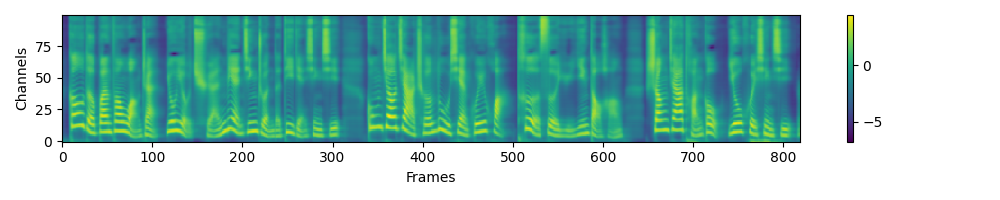

In [45]:
from PIL import Image
import numpy as np
from IPython.display import display
from ttts.utils.utils import plot_spectrogram_to_numpy
img = plot_spectrogram_to_numpy(mel[0, :, :].detach().unsqueeze(-1).cpu())
image = Image.fromarray(np.uint8(img))
display(image)

In [46]:
from ttts.vocoder.vocos import Vocos


vocos = Vocos.from_pretrained('pretrained_models/pytorch_model.bin','vocoder/config.yaml').to(device)
audio = vocos.decode(mel)
print(audio.shape)
torchaudio.save('gen.wav',audio.detach().cpu(), 24000)

torch.Size([1, 209664])


In [47]:
latent = gpt(auto_conditioning, text_tokens,
    torch.tensor([text_tokens.shape[-1]], device=text_tokens.device), codes,
    torch.tensor([codes.shape[-1]*gpt.mel_length_compression], device=text_tokens.device),
    return_latent=True, clip_inputs=False).transpose(1,2)
latent.shape

torch.Size([1, 1024, 206])

In [48]:
from ttts.diffusion.train import do_spectrogram_diffusion
from ttts.utils.diffusion import SpacedDiffusion, space_timesteps, get_named_beta_schedule
from ttts.diffusion.aa_model import denormalize_tacotron_mel, normalize_tacotron_mel
# print(device)
diffusion = load_model('diffusion',MODELS['diffusion.pth'],'diffusion/config.yaml',device)
diffuser = SpacedDiffusion(use_timesteps=space_timesteps(1000, [50]), model_mean_type='epsilon',
                           model_var_type='learned_range', loss_type='mse', betas=get_named_beta_schedule('linear', 1000),
                           conditioning_free=True, conditioning_free_k=2., sampler='dpm++2m')
diffusion_conditioning = normalize_tacotron_mel(cond_mel)
mel = do_spectrogram_diffusion(diffusion, diffuser, latent, diffusion_conditioning, temperature=1.0)
wav = vocos.decode(mel)

Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 512, context_dim is 512 and using 8 heads.
Setting up Memo

100%|██████████| 50/50 [00:04<00:00, 12.26it/s]


In [49]:
from IPython.display import Audio
wav = wav.detach().cpu()
torchaudio.save('gen.wav',wav.detach().cpu(), 24000)
Audio(wav,rate=24000)

In [50]:
# from ttts.vocoder.vocos import Vocos
# from IPython.display import Audio
# vocoder = Vocos.from_pretrained("~/tortoise_plus_zh/ttts/pretrained_models/pytorch_model.bin","~/tortoise_plus_zh/ttts/vocoder/config.yaml")
# audio = vocoder.decode(mel.cpu())
# torchaudio.save('gen_0.wav',audio,24000)
# Audio('gen_0.wav')